# **Task A: Gender Classification (Binary)**

### **📌 COMSYS 2025 | Task A – Gender Classification Evaluation Script**
🔧 RECOMMENDED ENVIRONMENT:
- ✅ This script is best run on **Google Colab**.
- ✅ Please ensure your **Google Drive is mounted** in later steps.
- ✅ Recomended to use GPU (or Colab T4, if not available) for faster Execution

⚠️ **PRECAUTIONS:**
- Make sure your `--data_path` follows this structure:
```
    └── test_folder/
        ├── male/
        │   ├── img1.jpg
        └── female/
            ├── img2.jpg
```

* Do not use local OS paths like `G:/`, `C:\`, or relative `./` — only use Colab's `/content/drive/...` format as colab runs on cloud.
* Ensure all images are valid and readable (.jpg, .png).
* This script uses argparse. If you're running in Colab, simulated args are injected automatically.

## **1. Setting up & Installations  of the required library**

In [ ]:
# Installing required packages
!pip install -q torchvision timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.9 MB/s eta 0:00:00


In [ ]:
# Importing the basic libraries
import os
import shutil
import zipfile
from google.colab import files
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

print("✅ Setup complete. Now uploading dataset ZIP.")

✅ Setup complete. Now uploading dataset ZIP.


### **1.1 Uploading from Google Drive**

* 📦 **Step 1**: Mount Google Drive to access dataset and model files
* 📁 **Step 2**: Define the path to your dataset ZIP file stored in Drive
* 📂 **Step 3**: Unzip the dataset into the Colab working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount your Google Drive to /content/drive

# Define the ZIP path
zip_path = '/content/drive/MyDrive/COMSYS_25/Comys_Hackathon5.zip' ####### Seleect the desired path from yur Google drive

# ✅Unzip it
# -q: quiet mode (no output)
# -o: overwrite existing files if needed
!unzip -oq "$zip_path" -d /content/

# ✅This should list: Task_A/ and Task_B/ folders inside Comys_Hackathon5
!ls /content/Comys_Hackathon5

Mounted at /content/drive
Task_A	Task_B


### **1.2 Inspect Extracted Dataset Folders**

After extracting the dataset, this step verifies the internal structure of both **Task A (Gender Classification)** and **Task B (Face Matching)** folders.
Each task is expected to have a `train/` and `val/` subdirectory.

In [ ]:
import os

# ✅Define base path to the extracted dataset
base_path = '/content/Comys_Hackathon5'

# Print subfolders inside Task_A and Task_B to verify structure
print("Task A folders:", os.listdir(os.path.join(base_path, 'Task_A')))
print("Task B folders:", os.listdir(os.path.join(base_path, 'Task_B')))

Task A folders: ['val', 'train']
Task B folders: ['val', 'train']


## **2. Data Preprocessing**

### **2.1 Imports required for data preprocessing**

This block:

* Imports essential libraries for model building, data loading, and evaluation.
* Uses PyTorch and TorchVision for deep learning and image processing.
* Includes `WeightedRandomSampler` to help correct dataset imbalance during training.
* Imports scikit-learn metrics for validation and final evaluation.
* Defines image transformation steps that match training and test inputs.

In [ ]:
# ✅ PyTorch & TorchVision core components
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models

# 🧮 Utilities and preprocessing
from collections import Counter
from PIL import Image
import os

# 📊 Include required Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **2.2 Define Transformations and Custom Dataset for Gender Classification**

This section:

* Defines a data augmentation pipeline to simulate real-world visual distortions (e.g., blur, lighting changes), making the model more robust.

* Implements a custom `GenderDataset` class that:

     1. Loads images from `male/` and `female/` folders.
     2. Assigns label `0` for male and `1` for female.
     3. Applies the defined image transformations.

These steps are crucial for training a fair and distortion-resilient gender classification model.

Even though Task A is just gender classification, the dataset may contain:
* Low-resolution faces
* Slight blur, fog, or lighting issues
* Mild occlusion (e.g. glasses, partial shadows)

*Mild distortions are useful and intentional in Task A*

In [ ]:
# 🔁 Define training-time image augmentations to simulate visual noise, lighting, blur, etc.
transform = transforms.Compose([
    transforms.Resize((224, 224)),                                            # Resize all images to a fixed size
    transforms.RandomHorizontalFlip(),                                        # Random horizontal flip
    transforms.ColorJitter(brightness=0.4, contrast=0.3),                     # Random brightness and contrast changes
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.3),  # Random blur (30% chance)
    transforms.ToTensor(),                                                    # Convert PIL image to PyTorch tensor
    transforms.Normalize([0.5]*3, [0.5]*3)                                    # Normalize to [-1, 1] range
])

#### Update 2 ----------------- To simulate visual noise, blur, etc., modify your training transform:

# 🧩 Custom dataset class for Task A (Gender Classification)
class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        for label, gender in enumerate(['male', 'female']):
            gender_folder = os.path.join(root_dir, gender)
            for fname in os.listdir(gender_folder):
                if fname.endswith(('.jpg', '.png', '.jpeg')):
                    self.samples.append((os.path.join(gender_folder, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### **2.3 DataLoader - Prepare Datasets and Balance Gender Labels with Weighted Sampling**

This step:

* Loads gender classification data from the `train/` and `val/` folders using the custom dataset class.

* Computes the class distribution to identify imbalance (e.g., many more male images than female).

* Uses `WeightedRandomSampler` to ensure the model sees male and female images with equal frequency during training, improving fairness and generalization.

* Sets up PyTorch `DataLoader` for both training and validation.

In [ ]:
# 🧠 Use same paths and transform
train_path = '/content/Comys_Hackathon5/Task_A/train'
val_path = '/content/Comys_Hackathon5/Task_A/val'

# ✅ Load Datasets
train_dataset = GenderDataset(train_path, transform=transform)
val_dataset = GenderDataset(val_path, transform=transform)

# 🔍 Analyze class imbalance in the training set
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
print("🔍 Class counts:", class_counts)     # e.g., Counter({0: 1532, 1: 394})

# 📊 Create a list of sample weights: lower weight for majority class, higher for minority
weights = [1.0 / class_counts[label] for label in targets]
# 🔄 Weighted sampler ensures balanced mini-batches during training
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


# ✅ Use sampler in train_loader instead of shuffle
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

🔍 Class counts: Counter({0: 1532, 1: 394})


## **3. Train Gender Classifier**

### **3.1 Set Device, Compute Class Weights, and Define Loss Function**
This step:
* Detects if a GPU is available and sets it as the device (highly recommended in Colab for faster training).
* Computes class weights using sklearn to address gender label imbalance.
* Applies a weighted cross-entropy loss, giving more importance to the minority class (female) during training.

```
⚠️ Note: Using Google Colab's GPU (Runtime -> Change runtime type -> T4 GPU) is recommended to significantly speed up training.
```



In [ ]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [ ]:
# Runtime -> Change Runtime -> T4 GPU (Recommended)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 🧮 Compute class weights to balance 'male' (0) and 'female' (1)
all_labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(targets),
                                     y=targets)

# 📊 Convert to PyTorch tensor and move to device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#----- Update 7 --------------
# Keep using weighted loss as well
criterion = nn.CrossEntropyLoss(weight=class_weights)

### **3.2 Define the Model (ResNet50) and Optimizer**

Initially, we used Pretrained Model **ResNet18** for gender classification, but observed lower validation accuracy and weaker generalization under visual distortions.

To improve robustness and deeper feature extraction, we switched to **ResNet50**, a deeper and more expressive convolutional model.

In this step:
* We load a pretrained ResNet50 model from TorchVision.
* Replace the final classification layer with a 2-output `Linear` layer (for male/female).
* Move the model to GPU or CPU as per availability.
* Use the **weighted cross-entropy loss** to address class imbalance.
* Define the **Adam optimizer** with a learning rate of `1e-4`.

**📚 About ResNet50**

ResNet50 (Residual Network with 50 layers) is a widely used deep convolutional neural network architecture introduced by Microsoft Research in 2015 as part of the ResNet paper. It is known for its **residual connections** or "skip connections" that help in training very deep networks without vanishing gradients.

🔍 **Why ResNet50?**
* 🧠 **Deep & expressive**: ResNet50 has 50 layers, making it capable of learning complex features, such as subtle gender differences under varying lighting, pose, and noise conditions.

* 🛠 **Pretrained power**: When initialized with ImageNet pretrained weights, ResNet50 brings strong generalization ability even on small datasets like `FACECOM`.

* 💡 **Residual learning**: Allows information to bypass layers, making it easier to train deeper models — especially helpful under adverse visual conditions (theme of COMSYS).

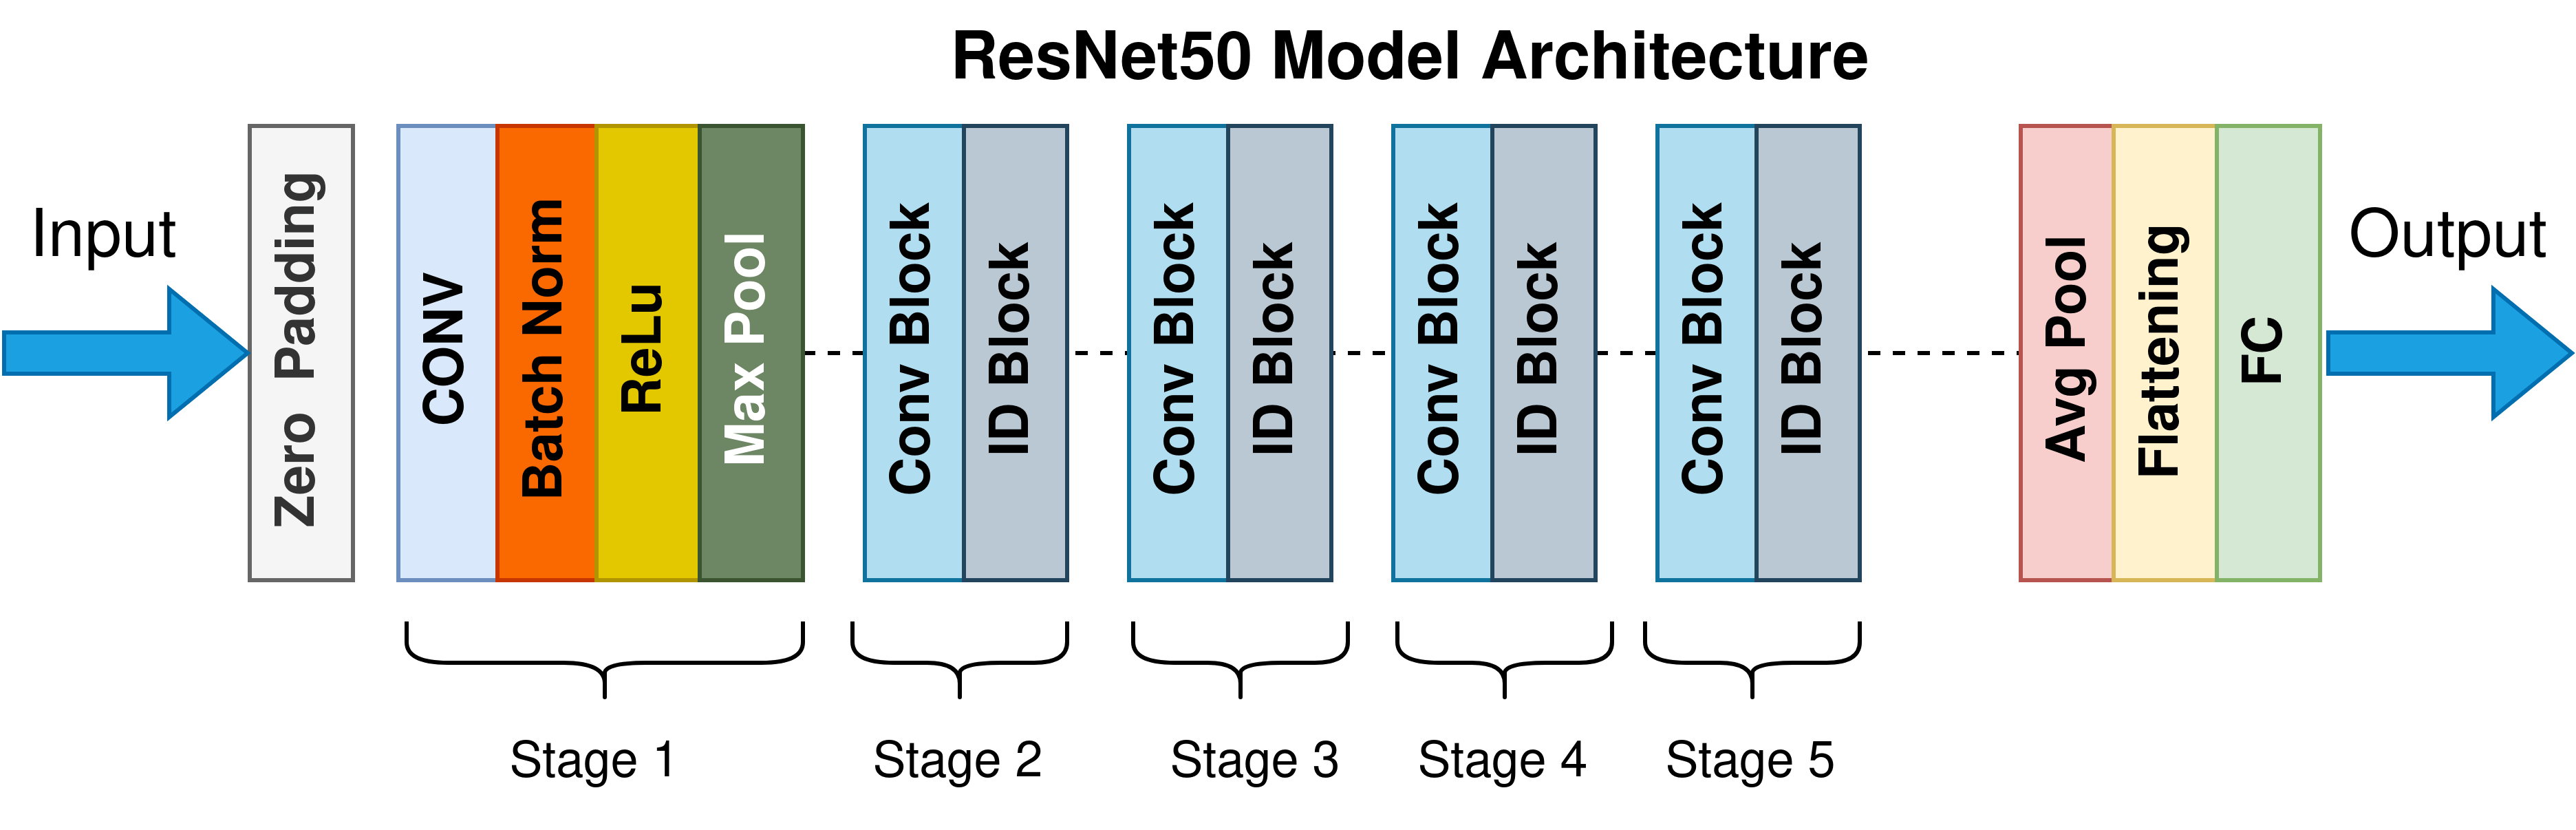


🚀 **Use in Task A:**

ResNet50 is used here as the backbone model for gender classification. By replacing its final layer with a 2-class output and fine-tuning on the FACECOM Task A dataset, it learns **to classify male vs female faces — even under blurred, foggy, or low-light conditions**.



In [ ]:
# 🔄 Previously used:
# model = models.resnet18(pretrained=True)

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
# Update 3  ----------------- Changing the model for deeper models learn more robust features.

model.fc = nn.Linear(model.fc.in_features, 2)  # 2 output classes
model = model.to(device)

# 🧠 Define weighted loss function (for class imbalance)
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# ⚙️ Optimizer (Adam works well with pretrained networks)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]
/tmp/ipython-input-11-2449472338.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

### **3.4 Define the Training Function**

This function performs one full epoch of training for the gender classification model.

🔧**What it does:**
* Sets the model in `train()` mode to enable layers like dropout and batch normalization.

* Iterates over all batches in the training dataloader.

* For each batch:

  * Moves data to the appropriate device (CPU/GPU).
  * Computes model predictions and loss.
  * Backpropagates the gradients and updates weights.

* Accumulates the average training loss across all batches.

In [ ]:
def train(model, dataloader, optimizer, criterion):
    """
    Perform one epoch of training for the given model.

    Args:
        model (torch.nn.Module): The classification model (e.g., ResNet50).
        dataloader (DataLoader): DataLoader for training data.
        optimizer (torch.optim.Optimizer): Optimizer (e.g., Adam).
        criterion (nn.Module): Loss function (CrossEntropyLoss with class weights).

    Returns:
        float: Average training loss for the epoch.
    """
    model.train()  # ✅ Enable training mode (for dropout, batchnorm)
    running_loss = 0.0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()         # 🔁 Reset gradients
        outputs = model(images)       # 🧠 Forward pass
        loss = criterion(outputs, labels)  # 🎯 Compute loss
        loss.backward()              # 🔄 Backpropagation
        optimizer.step()             # 🛠 Update weights

        running_loss += loss.item()  # 📊 Track total loss

    return running_loss / len(dataloader)  # 📉 Return average loss

### **3.5 Define the Evaluation Function**
This function evaluates the model's performance on the validation set.

🧠 What it does:
* Switches the model to `eval(`) mode to disable dropout and batch normalization updates.
* Loops through the validation dataloader **without gradient computation** for efficiency.
* Collects predictions and true labels.
* Calculates:

  * `Accuracy` – overall correctness
  * `Precision` – how many predicted positives were correct
  * `Recall` – how many actual positives were detected
  * `F1 Score` – harmonic mean of precision and recall

These metrics are essential for Task A and will be part of your submission report.



In [ ]:
def evaluate(model, dataloader):
    """
    Evaluate the model on the validation set.

    Args:
        model (torch.nn.Module): Trained classification model.
        dataloader (DataLoader): DataLoader for validation data.

    Returns:
        tuple: Accuracy, Precision, Recall, and F1-score
    """
    model.eval()  # ✅ Inference mode
    preds, targets = [], []

    with torch.no_grad():  # 🚫 No gradients needed during evaluation
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # 🎯 Get predicted class
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # 📊 Compute metrics
    acc = accuracy_score(targets, preds)
    precision = precision_score(targets, preds)
    recall = recall_score(targets, preds)
    f1 = f1_score(targets, preds)

    return acc, precision, recall, f1

### **3.7 Train the Model Across Epochs**
This section runs the full training loop across multiple epochs (default: 5), and prints validation metrics at the end of each epoch.

🔁 **For each epoch:**
Trains the model on the current batch of images using `train()`.

Evaluates the model on the validation set using `evaluate()`.

Logs the training loss and validation metrics (accuracy, precision, recall, and F1 score).

```
📝 Note: Increasing epochs from 3 → 5 improves learning and performance, especially with weighted loss and balanced sampling.
```

In [ ]:
# 🚀 Step 10: Train the model and evaluate performance after each epoch
EPOCHS = 5  # 🔁 Increased from 3 → 5 for better learning
print("🧠 Starting training...")

for epoch in range(EPOCHS):
    print(f"\n🌟 Epoch {epoch+1}/{EPOCHS}")

    # 🔁 Train for one epoch
    train_loss = train(model, train_loader, optimizer, criterion)

    # 🧪 Evaluate on validation set
    acc, prec, rec, f1 = evaluate(model, val_loader)

    # 📊 Display metrics
    print(f"📉 Loss: {train_loss:.4f}")
    print(f"✅ Accuracy: {acc:.4f} | 🎯 Precision: {prec:.4f} | 📊 Recall: {rec:.4f} | 🏆 F1: {f1:.4f}")

🧠 Starting training...

🌟 Epoch 1/5


Training: 100%|██████████| 61/61 [00:37<00:00,  1.61it/s]


📉 Loss: 0.1512
✅ Accuracy: 0.8791 | 🎯 Precision: 0.6901 | 📊 Recall: 0.9333 | 🏆 F1: 0.7935

🌟 Epoch 2/5


Training: 100%|██████████| 61/61 [00:35<00:00,  1.72it/s]


📉 Loss: 0.0449
✅ Accuracy: 0.9455 | 🎯 Precision: 0.9362 | 📊 Recall: 0.8381 | 🏆 F1: 0.8844

🌟 Epoch 3/5


Training: 100%|██████████| 61/61 [00:35<00:00,  1.73it/s]


📉 Loss: 0.0451
✅ Accuracy: 0.9218 | 🎯 Precision: 0.7857 | 📊 Recall: 0.9429 | 🏆 F1: 0.8571

🌟 Epoch 4/5


Training: 100%|██████████| 61/61 [00:37<00:00,  1.61it/s]


📉 Loss: 0.0157
✅ Accuracy: 0.9431 | 🎯 Precision: 0.8584 | 📊 Recall: 0.9238 | 🏆 F1: 0.8899

🌟 Epoch 5/5


Training: 100%|██████████| 61/61 [00:37<00:00,  1.61it/s]


📉 Loss: 0.0191
✅ Accuracy: 0.9526 | 🎯 Precision: 0.9670 | 📊 Recall: 0.8381 | 🏆 F1: 0.8980


### **3.8 Save the Best Model Based on F1 Score**
To ensure only the most performant version of the model is saved, we:

* Track the highest F1 score achieved during training

* Save the model's weights (using `torch.save`) only when a new best F1 score is reached

This prevents overfitting and guarantees that the final model is the **most generalizable** version observed during training.

The saved model will later be used for inference on unseen test images.



In [ ]:
best_f1 = 0
for epoch in range(EPOCHS):
    ...
    _, _, _, f1 = evaluate(model, val_loader)
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), "/content/drive/MyDrive/COMSYS_25/gender_model3.pth")

# 💾 Save the best model based on F1-score during validation

## **4. Validation**

In [ ]:
import os, sys
import argparse
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **4.1 Setup for Google Colab**
To allow `argpars`-based scripts to run inside Google Colab, we simulate command-line arguments using `sys.argv` when the code detects it’s running in a Colab environment.

This lets you:
* Run test_task_a script
* Still test it interactively inside Google Colab **without needing terminal-style arguments**

```
Note: Carefully place the path of the folder from Google Drive if already mounted
```

**Folder Structure**

```
MyDrive/
└── COMSYS_25/
    ├── gender_model3.pth
    └── TaskA_testing/
        ├── male/
        │   └── img1.jpg
        └── female/
            └── img2.jpg
```

In [ ]:
# ✅ Inject fake command-line args when running in Colab
if 'google.colab' in sys.modules:
    sys.argv = [
        'test_task_a.py',
        '--data_path', '/content/drive/MyDrive/COMSYS_25/TaskA_testing',
        '--model_path', '/content/drive/MyDrive/COMSYS_25/gender_model3.pth'
    ]

# -------------------------------
# 🔧 Set up argument parser
# -------------------------------
parser = argparse.ArgumentParser(description="Evaluate Gender Classification Model")
parser.add_argument('--data_path', type=str, required=True, help='/content/drive/MyDrive/COMSYS_25/TaskA_testing')
parser.add_argument('--model_path', type=str, required=True, help='/content/drive/MyDrive/COMSYS_25/gender_model3.pth')
args = parser.parse_args()

In [ ]:
# -------------------------------
# 🔧 Device & Transform
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

### **4.2 Load the Trained Gender Classification Model**
This section:
* Loads the pretrained **ResNet50 model architecture**
* Replaces the final layer to output **2 classes** (Male / Female)
* Loads your fine-tuned weights (`gender_model3.pth`)
* Moves the model to GPU or CPU as per availability
* Sets the model to evaluation mode (`model.eval()`) to disable dropout and batch norm updates



In [ ]:
# -------------------------------
# 🔧 Load Model
# -------------------------------
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### **4.3 Perform Inference on the Validation Folder**
This section:

* Iterates over test data folders named `male/` and `female/`

* For each image:
  * Applies the same transform as training
  * Passes it through the model
  * Collects predictions and true labels

* Builds `y_true` and `y_pred` lists for metric calculation

```
🛡️ Skips unreadable or corrupted files safely
```

In [ ]:
# -------------------------------
# 🔍 Inference on test folder
# -------------------------------
label_map = {'male': 0, 'female': 1}
y_true, y_pred = [], []

for gender in ['male', 'female']:
    folder_path = os.path.join(data_path, gender)
    if not os.path.isdir(folder_path):
        continue

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(folder_path, fname)
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            print(f"⚠️ Skipping unreadable image: {img_path}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred = torch.argmax(output, dim=1).item()

        y_true.append(label_map[gender])
        y_pred.append(pred)

### **4.4 Compute and Print Evaluation Metrics**
After collecting predictions (y_pred) and true labels (y_true), this step calculates:

| Metric           | Meaning                                                          |
| ---------------- | ---------------------------------------------------------------- |
| ✅ **Accuracy**   | Overall correctness of the model                                 |
| 🎯 **Precision** | How many predicted “female” labels were actually correct         |
| 📈 **Recall**    | How many actual “female” images were correctly predicted         |
| 🏆 **F1 Score**  | Balance between Precision and Recall (used to decide best model) |


In [ ]:
# -------------------------------
# 📊 Report metrics
# -------------------------------
print("\n📊 Evaluation Metrics (Task A):")
print(f"✅ Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
print(f"🎯 Precision : {precision_score(y_true, y_pred):.4f}")
print(f"📈 Recall    : {recall_score(y_true, y_pred):.4f}")
print(f"🏆 F1 Score  : {f1_score(y_true, y_pred):.4f}")


📊 Evaluation Metrics (Task A):
✅ Accuracy  : 0.9621
🎯 Precision : 0.9890
📈 Recall    : 0.8571
🏆 F1 Score  : 0.9184


## **5. Manual Testing via direct image upload**

Saving Lata-Mangeshkar-Biography.png to Lata-Mangeshkar-Biography.png


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


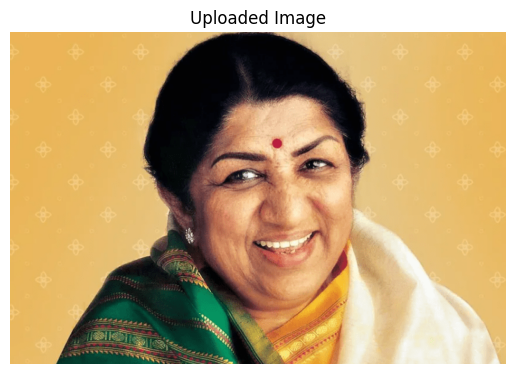


👤 Predicted Gender: Female
🎯 Confidence: 94.90%


In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

# 📤 Upload test image
uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]

# 🧠 Reload the model (if not already loaded)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/COMSYS_25/gender_model3.pth', map_location=device))
model = model.to(device)
model.eval()

# 🔧 Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 🖼 Load and display image
image = Image.open(test_image_path).convert("RGB")
plt.imshow(image)
plt.title("Uploaded Image")
plt.axis("off")
plt.show()

# 🎯 Predict gender
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    probs = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

label_map = {0: "Male", 1: "Female"}
confidence = probs[0][predicted_class].item() * 100

# 🗣️ Display result
print(f"\n👤 Predicted Gender: {label_map[predicted_class]}")
print(f"🎯 Confidence: {confidence:.2f}%")


# END